In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [47]:
%cd /content/drive/MyDrive/projects/Opt4ML/batch-norm-helps-optimization

/content/drive/MyDrive/projects/Opt4ML/batch-norm-helps-optimization


# Internal Covariate Shift (ICS) in VGG without and with BatchNorm

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-1f0008edec47>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


In [2]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
import torch
from torchvision import transforms, utils
import torchvision.models as models
import torchvision.datasets as datasets
import os
import sys
import random
from tqdm import tqdm as tqdm
from IPython import display
import importlib

#### Constants (parameters) initialization

In [9]:
device_id = 0
num_workers = 4

batch_size = 128
default_learning_rate = 0.1

In [50]:
# add our package dir to path
module_path = os.getcwd()
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

In [51]:
figures_path

'/content/drive/MyDrive/projects/Opt4ML/batch-norm-helps-optimization/reports/figures'

Make sure we are using the right device.

In [11]:
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
Tesla T4


## CIFAR-10 data load

In [52]:
from src.data.loaders import get_cifar_loader

In [13]:
train_loader = get_cifar_loader(batch_size=batch_size, train=True)
val_loader = get_cifar_loader(batch_size=batch_size, train=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 48867500.08it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


Make sure that dataloader works as expected by observing one sample from it.

tensor([[[ 0.9922,  0.9608,  0.9686,  ...,  0.9765,  0.9765,  0.9765],
         [ 0.9373,  0.8980,  0.9216,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9529,  0.9137,  0.9216,  ...,  0.8824,  0.8275,  0.8824],
         ...,
         [-0.1529, -0.1686, -0.1373,  ..., -0.1137, -0.0196,  0.1608],
         [-0.1373, -0.1529, -0.1373,  ..., -0.0431,  0.0275,  0.1529],
         [-0.1451, -0.1294, -0.1451,  ...,  0.1137,  0.1373,  0.1529]],

        [[ 0.9373,  0.9137,  0.9216,  ...,  0.9608,  0.9686,  0.9765],
         [ 0.8275,  0.7882,  0.8118,  ...,  0.9529,  0.9686,  0.9843],
         [ 0.8980,  0.8588,  0.8588,  ...,  0.8118,  0.7725,  0.8431],
         ...,
         [-0.1529, -0.1686, -0.1373,  ..., -0.0588,  0.0353,  0.2000],
         [-0.1373, -0.1529, -0.1373,  ...,  0.0118,  0.0824,  0.2000],
         [-0.1451, -0.1294, -0.1451,  ...,  0.1765,  0.2000,  0.2157]],

        [[ 0.8667,  0.8431,  0.8510,  ...,  0.9451,  0.9373,  0.9451],
         [ 0.6941,  0.6549,  0.6784,  ...,  0

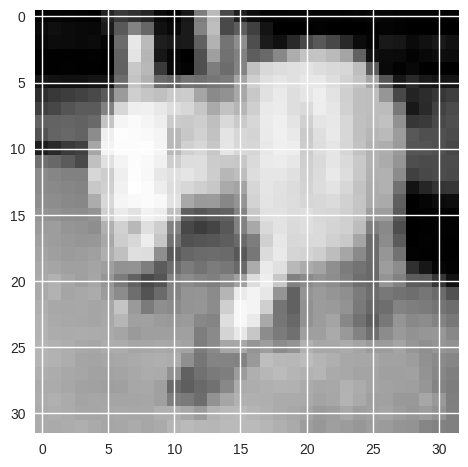

In [14]:
for X,y in train_loader:
    print(X[0])
    print(y[0])
    print(X[0].shape)
    plt.imshow(np.array(X[0,0,:,:]))
    print(X[0].max())
    print(X[0].min())
    break

## Models
Let's have a look at VGG-A models without and with BatchNorm

In [15]:
def get_number_of_parameters(model):
    parameters_n = 0
    for parameter in model.parameters():
        parameters_n += np.prod(parameter.shape).item()

    return parameters_n

In [16]:
import src.models.vgg as vgg
#importlib.reload(vgg)

In [17]:
model = vgg.VGGA()
print('Number of parameters: ', get_number_of_parameters(model))
print(model)

Number of parameters:  9750922
VGGA(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0

In [18]:
model = vgg.VGGABatchNorm()
print('Number of parameters: ', get_number_of_parameters(model))
print(model)

Number of parameters:  9758474
VGGABatchNorm(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): 

##### define magic constants
IDs of 5-th and 10-th layers for VGG and VGG + BatchNorm models

In [19]:
vgg_layer_5_id = 11 # in features
vgg_layer_10_id = 2 # in classifier

vgg_bn_layer_5_id = 15 # in features
vgg_bn_layer_10_id = 3 # in classifier

## Final preparations for experiments

In [20]:
def get_vgg_weights(model):
    # features submodule
    features_weights = []
    features_bias = []
    # classifier submodule
    classifier_weights = []
    classifier_bias = []

    for i in range(len(model.features)):
        m = model.features[i]
        if hasattr(m, 'weight'):
            features_weights.append(m.weight.data.clone())
        if hasattr(m, 'bias'):
            features_bias.append(m.bias.data.clone())

    for i in range(len(model.classifier)):
        m = model.classifier[i]
        if hasattr(m, 'weight'):
            classifier_weights.append(m.weight.data.clone())
        if hasattr(m, 'bias'):
            classifier_bias.append(m.bias.data.clone())

    weights = features_weights, features_bias, classifier_weights, classifier_bias

    return weights


def set_vgg_weights(model, weights, feature_border=None, classifier_border=None):
    features_weights, features_bias, classifier_weights, classifier_bias = weights

    weight_idx = 0
    bias_idx = 0
    for i in range(len(model.features)):
        if feature_border == i:
            return

        m = model.features[i]
        if hasattr(m, 'weight'):
            m.weight.data = features_weights[weight_idx]
            weight_idx += 1
        if hasattr(m, 'bias'):
            m.bias.data = features_bias[bias_idx]
            bias_idx += 1

    weight_idx = 0
    bias_idx = 0
    for i in range(len(model.classifier)):
        if classifier_border == i:
            return

        m = model.classifier[i]
        if hasattr(m, 'weight'):
            m.weight.data = classifier_weights[weight_idx]
            weight_idx += 1
        if hasattr(m, 'bias'):
            m.bias.data = classifier_bias[bias_idx]
            bias_idx += 1
    return

In [21]:
def get_accuracy(model, dataloader, device='cpu'):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  ## <---
            y = y.to(device)  ## <---
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

In [22]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [23]:
def train_calculate_ICS(model,
                        optimizer,
                        criterion,
                        train_loader,
                        val_loader,
                        epochs_n,
                        layer_5_id,
                        layer_10_id):
    """
    Calculates ICS for layers 5 (Conv2d) and 10 (Linear)
    """

    batches_n = len(train_loader)
    batches_total = batches_n * epochs_n


    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    # here loss gradients for layers will be stored
    G_5 = [np.nan] * batches_total
    G_5_new = [np.nan] * batches_total
    G_10 = [np.nan] * batches_total
    G_10_new = [np.nan] * batches_total

    # here ICS results will be stored
    l2_diff_5 = [np.nan] * batches_total
    l2_diff_10 = [np.nan] * batches_total

    batches_n = len(train_loader)

    for epoch in tqdm(range(epochs_n), unit='epoch'):
        model.train()

        learning_curve[epoch] = 0
        for batch, data in enumerate(train_loader):
            step_num = epoch * batches_n + batch

            x, y = data
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            learning_curve[epoch] += loss.item()
            loss.backward()

            # experiment's core

            # save weights
            current_weights = get_vgg_weights(model)
            G_5 = model.features[layer_5_id].weight.grad.clone()
            G_10 = model.classifier[layer_10_id].weight.grad.clone()

            # perform optimizer's step
            optimizer.step()

            # save new weights
            new_weights = get_vgg_weights(model)

            # for layer 5
            set_vgg_weights(model, current_weights)
            set_vgg_weights(model, new_weights, feature_border=layer_5_id)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            loss.backward()
            G_5_new = model.features[layer_5_id].weight.grad.clone()

            # for layer 10
            set_vgg_weights(model, new_weights, classifier_border=layer_10_id)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            loss.backward()
            G_10_new = model.classifier[layer_10_id].weight.grad.clone()

            # set all weights to new
            set_vgg_weights(model, new_weights)

            # calculate ICS results
            l2_diff_5[step_num] = torch.norm(G_5 - G_5_new, 2)
            l2_diff_10[step_num] = torch.norm(G_10 - G_10_new, 2)

        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)

        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch

        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    print('Experiment finished')

    return learning_curve, train_accuracy_curve, val_accuracy_curve, l2_diff_5, l2_diff_10

## Perform experiments

In [24]:
training_results = {}

In [25]:
lr = 5e-4

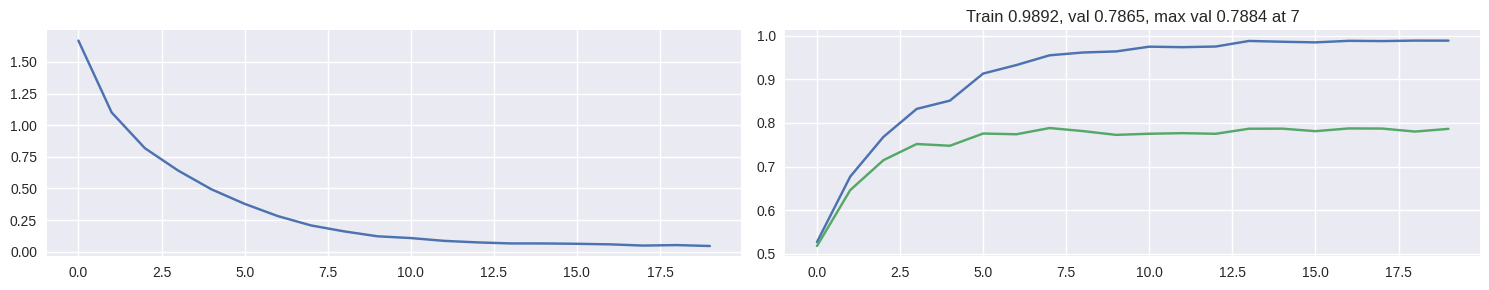

100%|██████████| 20/20 [17:20<00:00, 52.03s/epoch]

Experiment finished


In [26]:
model_name = 'VGG'
experimment_name = f'{model_name}_lr_{lr}'

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGA()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train_calculate_ICS(model,
                                                         optimizer,
                                                         criterion,
                                                         train_loader,
                                                         val_loader,
                                                         epochs_n=20,
                                                         layer_5_id=vgg_layer_5_id,
                                                         layer_10_id=vgg_layer_10_id)

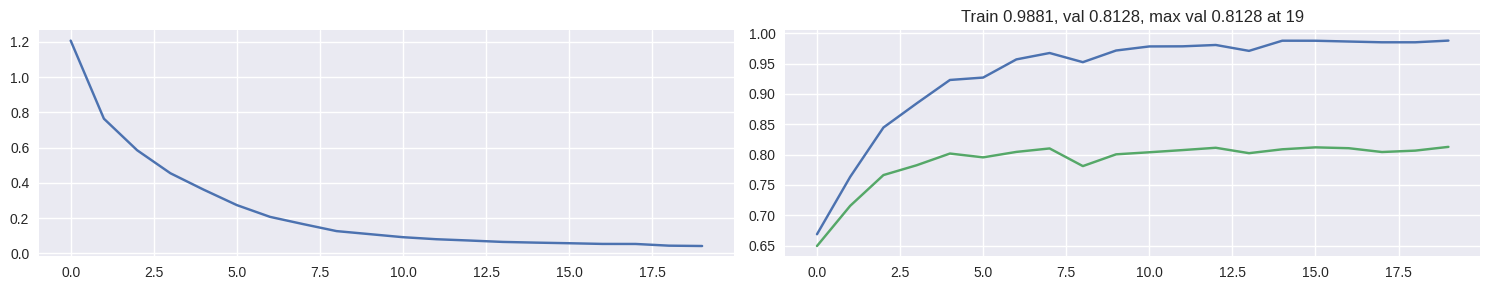

100%|██████████| 20/20 [18:22<00:00, 55.11s/epoch]

Experiment finished


In [27]:
model_name = 'VGG_BN'
experimment_name = f'{model_name}_lr_{lr}'

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGABatchNorm()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train_calculate_ICS(model,
                                                         optimizer,
                                                         criterion,
                                                         train_loader,
                                                         val_loader,
                                                         epochs_n=20,
                                                         layer_5_id=vgg_bn_layer_5_id,
                                                         layer_10_id=vgg_bn_layer_10_id)

In [28]:
lr = 1e-3

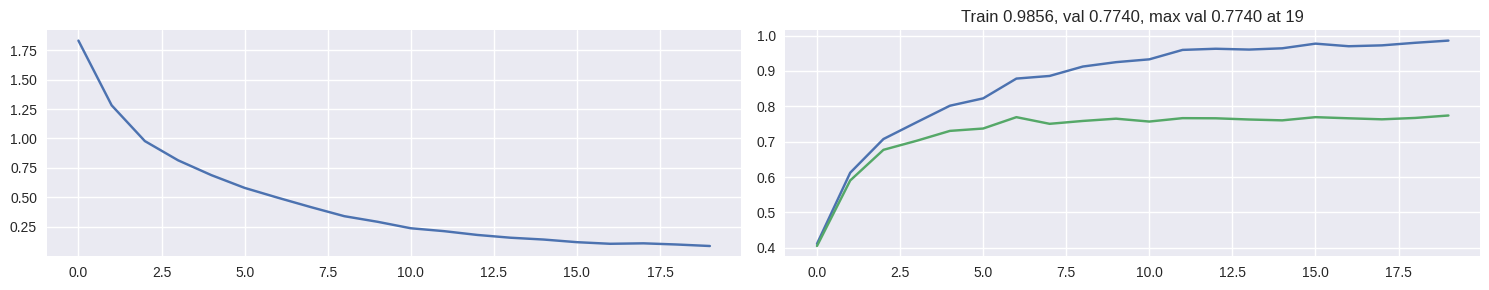

100%|██████████| 20/20 [16:44<00:00, 50.23s/epoch]

Experiment finished


In [29]:
model_name = 'VGG'
experimment_name = f'{model_name}_lr_{lr}'

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGA()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train_calculate_ICS(model,
                                                         optimizer,
                                                         criterion,
                                                         train_loader,
                                                         val_loader,
                                                         epochs_n=20,
                                                         layer_5_id=vgg_layer_5_id,
                                                         layer_10_id=vgg_layer_10_id)

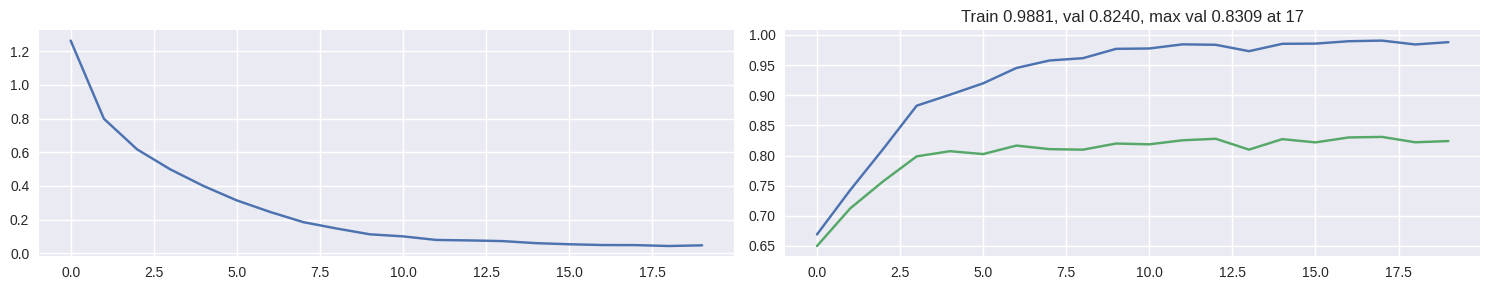

100%|██████████| 20/20 [18:22<00:00, 55.13s/epoch]

Experiment finished


In [30]:
model_name = 'VGG_BN'
experimment_name = f'{model_name}_lr_{lr}'

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGABatchNorm()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train_calculate_ICS(model,
                                                         optimizer,
                                                         criterion,
                                                         train_loader,
                                                         val_loader,
                                                         epochs_n=20,
                                                         layer_5_id=vgg_bn_layer_5_id,
                                                         layer_10_id=vgg_bn_layer_10_id)

## Plot results

```python
result = (learning_curve, train_accuracy_curve, val_accuracy_curve, l2_diff_5, l2_diff_10)
```

In [31]:
experiments = [name for name in training_results.keys()]
print(experiments)

['VGG_lr_0.0005', 'VGG_BN_lr_0.0005', 'VGG_lr_0.001', 'VGG_BN_lr_0.001']


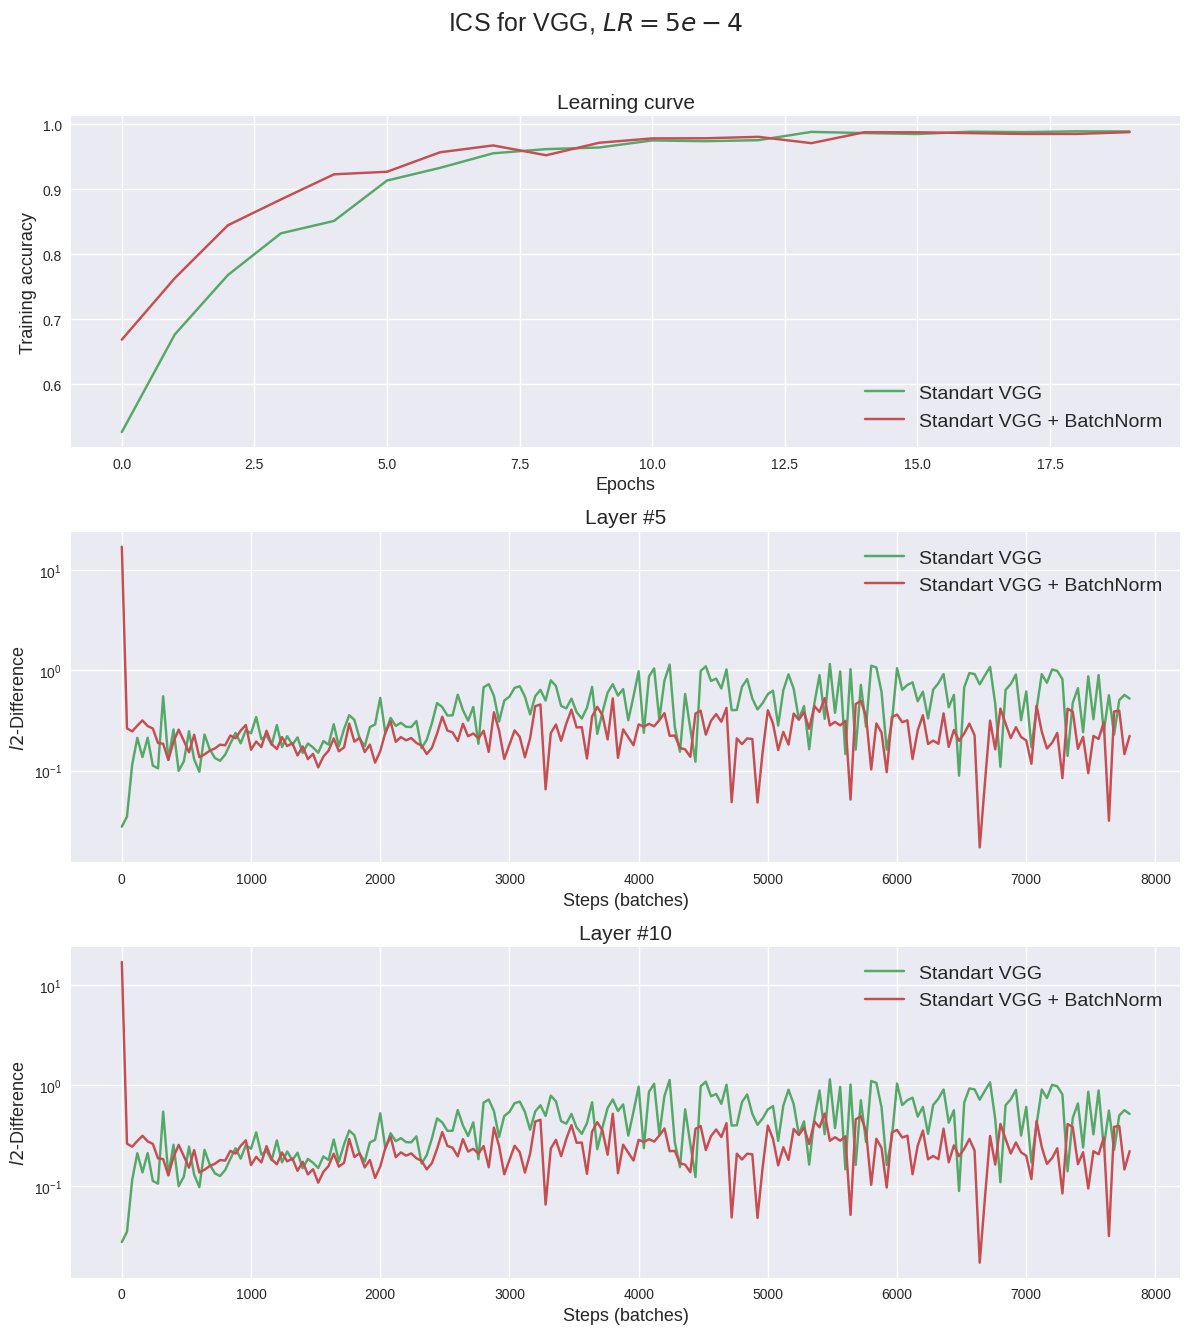

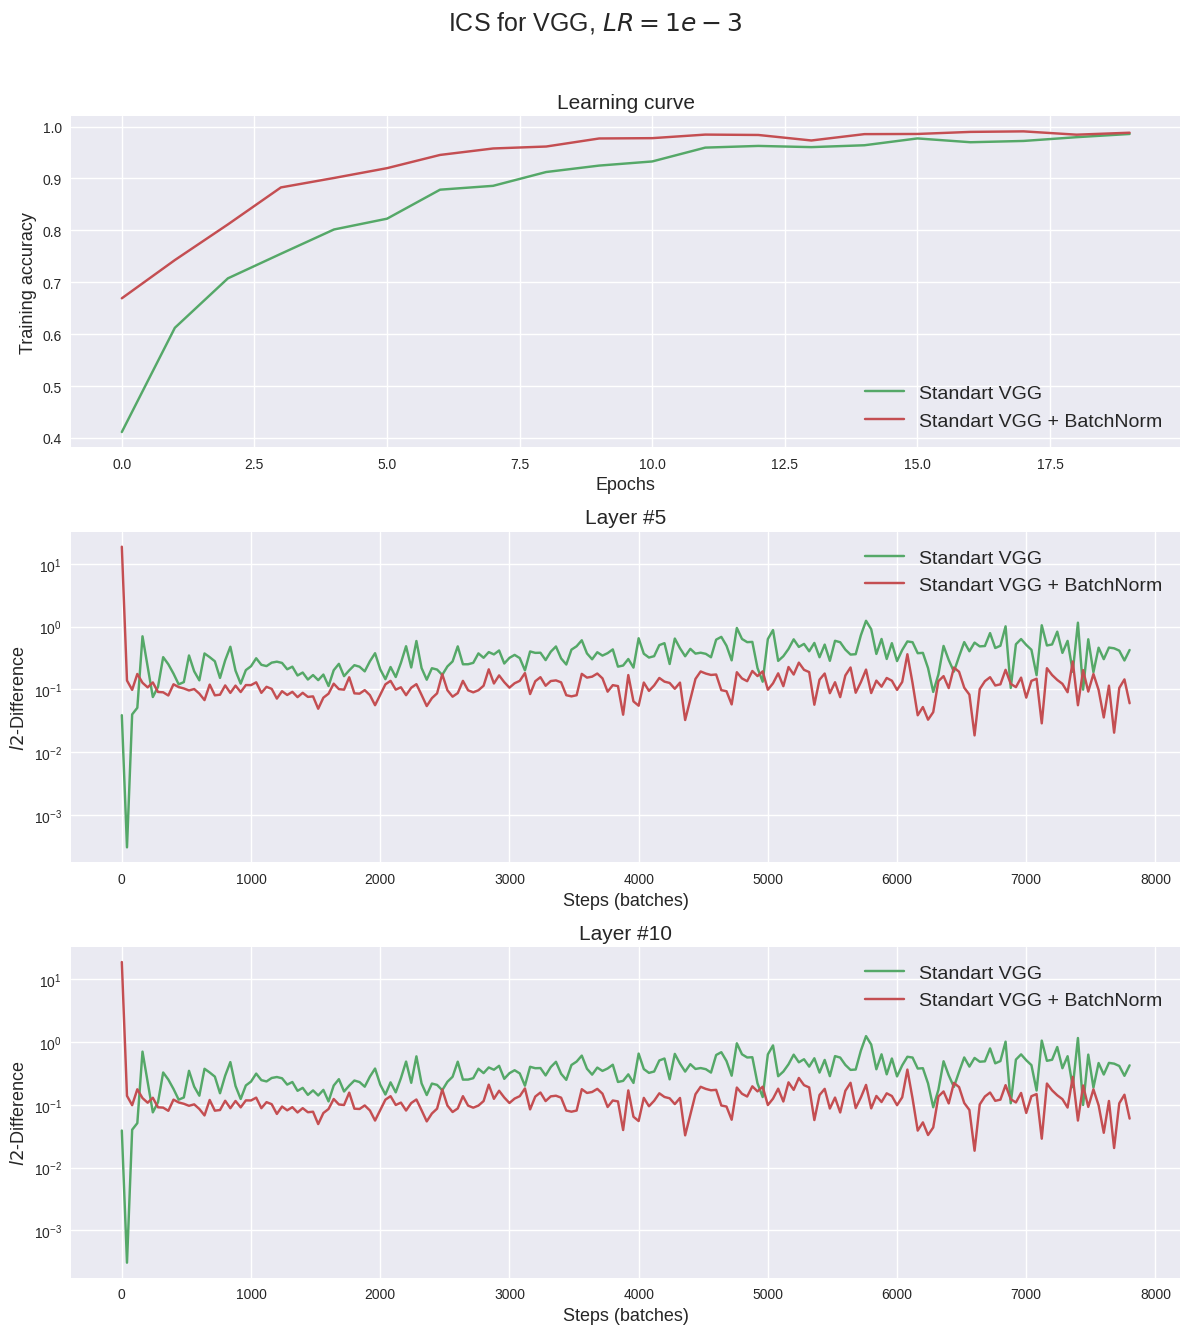

In [53]:
start_from = 0
step = 40
total_steps_n = len(training_results['VGG_lr_0.0005'][3])
steps_for_plot = np.arange(start_from, total_steps_n, step)

# first learning rate
fig, axs = plt.subplots(3, 1, figsize=(12, 14))
fig.suptitle('ICS for VGG, $LR = 5e-4$', fontsize=18)

curr_exper = 'VGG_lr_0.0005'
curr_results = training_results[curr_exper]
i = 0
axs[i].plot(curr_results[1], color='C1', label='Standart VGG')
axs[i].set_title('Learning curve', fontsize=15)
axs[i].set_ylabel('Training accuracy', fontsize=13)
axs[i].set_xlabel('Epochs', fontsize=13)
i = 1
axs[i].semilogy(steps_for_plot, [r.cpu() for r in curr_results[3][start_from::step]], color='C1', label='Standart VGG')
axs[i].set_title('Layer #5', fontsize=15)
axs[i].set_ylabel('$l2$-Difference', fontsize=13)
axs[i].set_xlabel('Steps (batches)', fontsize=13)
i = 2
axs[i].semilogy(steps_for_plot, [r.cpu() for r in curr_results[3][start_from::step]], color='C1', label='Standart VGG')
axs[i].set_title('Layer #10', fontsize=15)
axs[i].set_ylabel('$l2$-Difference', fontsize=13)
axs[i].set_xlabel('Steps (batches)', fontsize=13)

curr_exper = 'VGG_BN_lr_0.0005'
curr_results = training_results[curr_exper]
i = 0
axs[i].plot(curr_results[1], color='C2', label='Standart VGG + BatchNorm')
axs[i].legend(fontsize=14)
i = 1
axs[i].semilogy(steps_for_plot, [r.cpu() for r in curr_results[3][start_from::step]], color='C2', label='Standart VGG + BatchNorm')
axs[i].legend(fontsize=14)
i = 2
axs[i].semilogy(steps_for_plot, [r.cpu() for r in curr_results[3][start_from::step]], color='C2', label='Standart VGG + BatchNorm')
axs[i].legend(fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(os.path.join(figures_path, 'ICS_l2_VGG_LR_5e-4.png'), dpi=300)
plt.show()

# second learning rate
fig, axs = plt.subplots(3, 1, figsize=(12, 14))
fig.suptitle('ICS for VGG, $LR = 1e-3$', fontsize=18)

curr_exper = 'VGG_lr_0.001'
curr_results = training_results[curr_exper]
i = 0
axs[i].plot(curr_results[1], color='C1', label='Standart VGG')
axs[i].set_title('Learning curve', fontsize=15)
axs[i].set_ylabel('Training accuracy', fontsize=13)
axs[i].set_xlabel('Epochs', fontsize=13)
i = 1
axs[i].semilogy(steps_for_plot, [r.cpu() for r in curr_results[3][start_from::step]], color='C1', label='Standart VGG')
axs[i].set_title('Layer #5', fontsize=15)
axs[i].set_ylabel('$l2$-Difference', fontsize=13)
axs[i].set_xlabel('Steps (batches)', fontsize=13)
i = 2
axs[i].semilogy(steps_for_plot, [r.cpu() for r in curr_results[3][start_from::step]], color='C1', label='Standart VGG')
axs[i].set_title('Layer #10', fontsize=15)
axs[i].set_ylabel('$l2$-Difference', fontsize=13)
axs[i].set_xlabel('Steps (batches)', fontsize=13)

curr_exper = 'VGG_BN_lr_0.001'
curr_results = training_results[curr_exper]
i = 0
axs[i].plot(curr_results[1], color='C2', label='Standart VGG + BatchNorm')
axs[i].legend(fontsize=14)
i = 1
axs[i].semilogy(steps_for_plot, [r.cpu() for r in curr_results[3][start_from::step]], color='C2', label='Standart VGG + BatchNorm')
axs[i].legend(fontsize=14)
i = 2
axs[i].semilogy(steps_for_plot, [r.cpu() for r in curr_results[3][start_from::step]], color='C2', label='Standart VGG + BatchNorm')
axs[i].legend(fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(os.path.join(figures_path, 'ICS_l2_VGG_LR_1e-3.png'), dpi=300)
plt.show()